In [1]:
import backtester272 as bt
import pandas as pd
import numpy as np

# Load data

In [2]:
def load_data(name):
    data = pd.read_csv(f'data/{name}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.sort_index()
    return data


benchmark = load_data('benchmark')
weights = load_data('weights')  
sectors = load_data('sectors')


/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_8046/2173346043.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [3]:
wip = bt.Backtester(sectors, benchmark_weights=weights)

In [8]:
start_date = sectors.index[0].strftime('%Y-%m-%d')
end_date = sectors.index[-1].strftime('%Y-%m-%d')

global_params = {
    'start_date': start_date,
    'end_date': end_date,
    'freq': 182,
    'window': 182,
    'aum': 100,
    'transaction_cost': 0.05
}

global_constraints = {
    'max_weight': 0.35,
    'min_weight': 0.025,
    'risk_free_rate': 0.02,
    'total_exposure': 1.0,
    'max_turnover': 2,
    'max_tracking_error': 0.05
}

MS = wip.run(**global_params, strategy=bt.MaxSharpeStrategy(**global_constraints))
ERC = wip.run(**global_params, strategy=bt.EqualRiskContributionStrategy(**global_constraints))
EW = wip.run(**global_params, strategy=bt.EqualWeightStrategy())
MV = wip.run(**global_params, strategy=bt.MinVarianceStrategy(**global_constraints))

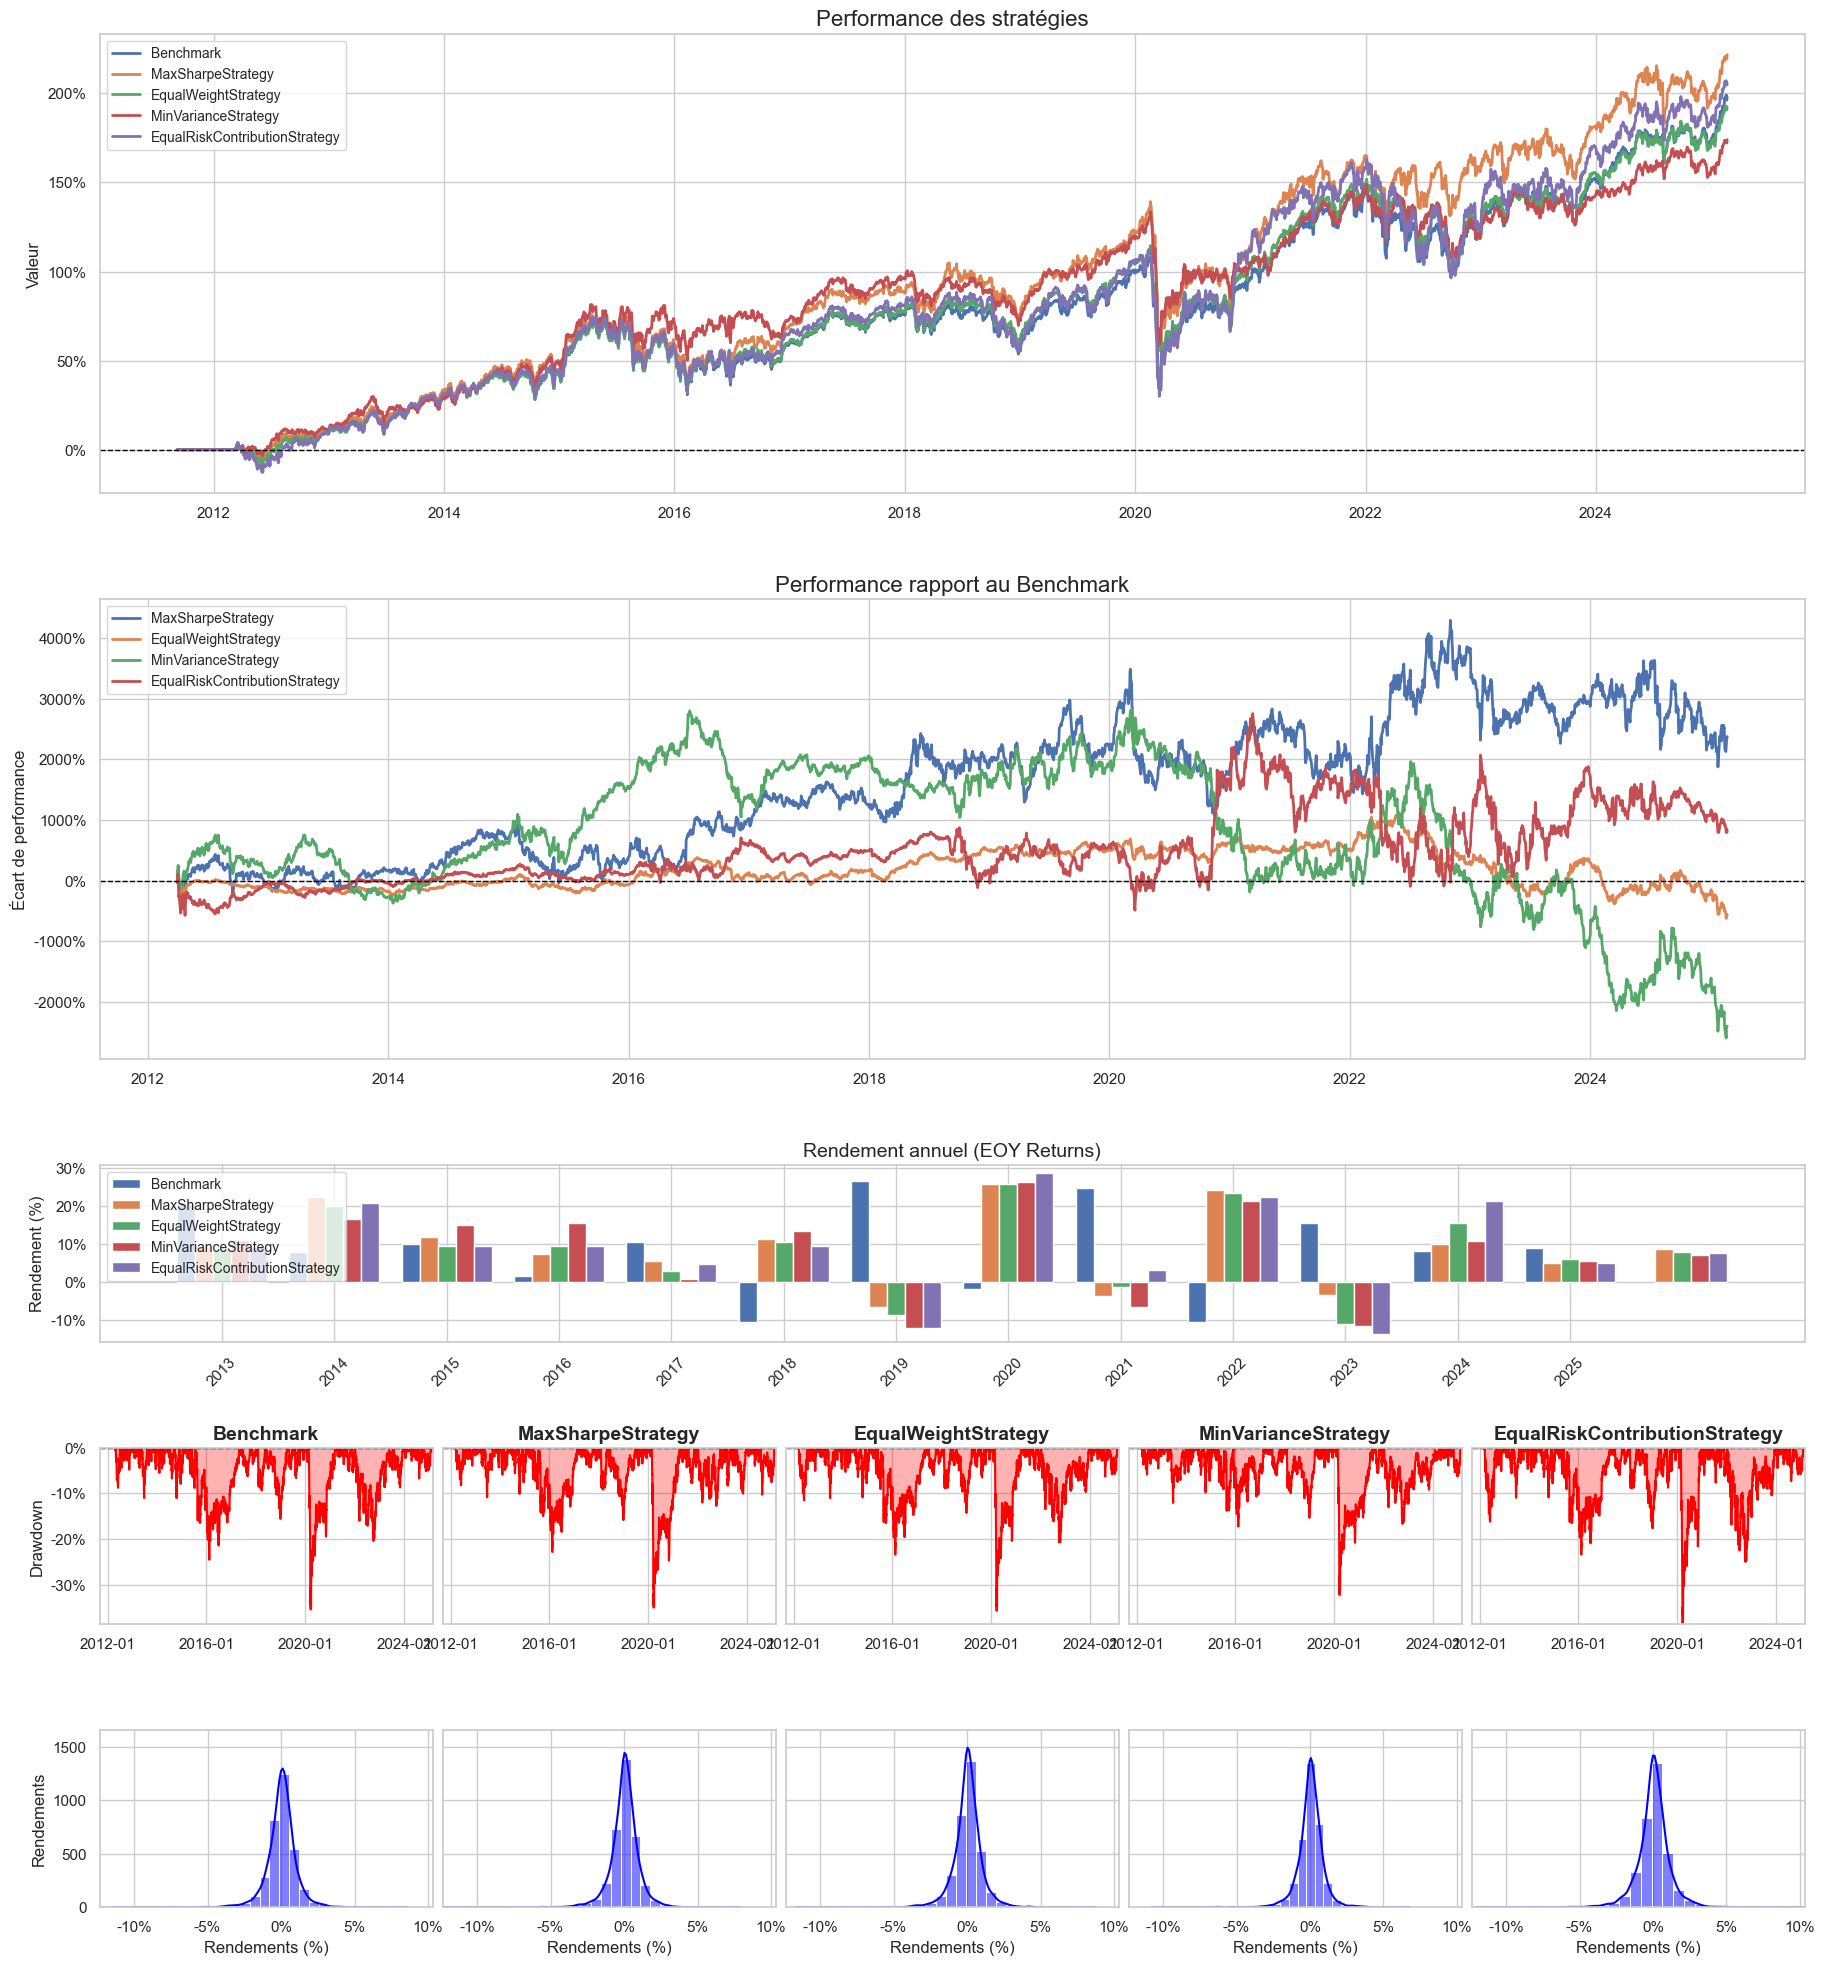

|                              | Benchmark   | MaxSharpeStrategy   | EqualWeightStrategy   | MinVarianceStrategy   | EqualRiskContributionStrategy   |
|:-----------------------------|:------------|:--------------------|:----------------------|:----------------------|:--------------------------------|
| Performance                  | 197.94%     | 221.67%             | 192.20%               | 174.02%               | 205.94%                         |
| CAGR                         | 8.67%       | 8.89%               | 8.13%                 | 7.63%                 | 8.50%                           |
| Volatility                   | 15.44%      | 14.91%              | 15.09%                | 13.39%                | 17.31%                          |
| Max Drawdown                 | -35.43%     | -35.01%             | -35.74%               | -32.23%               | -38.72%                         |
| Sharpe Ratio                 | 0.62        | 0.65                | 0.59                  | 0

In [9]:
MS.compare(EW, MV, ERC)

In [10]:
MS.positions('benchmark')
MS.positions()

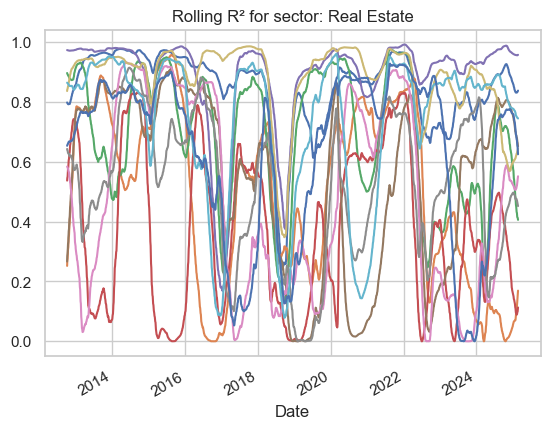

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def rolling_regression_R2(y, X, window=60):
    """
    Calcule le R² d'une régression linéaire sur une fenêtre roulante.
    
    Args:
        y (pd.Series): Série temporelle du benchmark.
        X (pd.Series): Série temporelle d'un secteur.
        window (int): Taille de la fenêtre roulante.
    
    Returns:
        pd.Series: R² pour chaque fenêtre roulante.
    """
    r2_values = []
    # Indices sur lesquels le R² sera calculé
    index = y.index[window - 1:]
    for i in range(window, len(y) + 1):
        y_window = y.iloc[i - window:i]
        X_window = X.iloc[i - window:i]
        # Ajout d'une constante pour l'intercept
        X_window_const = sm.add_constant(X_window)
        model = sm.OLS(y_window, X_window_const).fit()
        r2_values.append(model.rsquared)
    return pd.Series(r2_values, index=index)

# Supposons que benchmark contient les rendements du benchmark
# et sectors est un DataFrame où chaque colonne correspond aux rendements d'un secteur.
# Par exemple, vous pouvez calculer les rendements si ce sont des prix :
# benchmark = benchmark.pct_change().dropna()
# sectors = sectors.pct_change().dropna()

window = 365  # fenêtre de 60 périodes

# Créer un dictionnaire pour stocker le R² roulants pour chaque secteur
rolling_r2 = {}

for sector in sectors.columns:
    # Assurez-vous que les index des séries sont alignés
    aligned_data = pd.concat([benchmark, sectors[sector]], axis=1, join='inner')
    aligned_data.columns = ['benchmark', 'sector']
    r2_series = rolling_regression_R2(aligned_data['benchmark'], aligned_data['sector'], window)
    rolling_r2[sector] = r2_series

# Par exemple, pour afficher le R² roulant d'un secteur donné :
sector_to_plot = sectors.columns[0]
for sector_to_plot in sectors.columns:
    rolling_r2[sector_to_plot].plot(title=f"Rolling R² for sector: {sector_to_plot}")

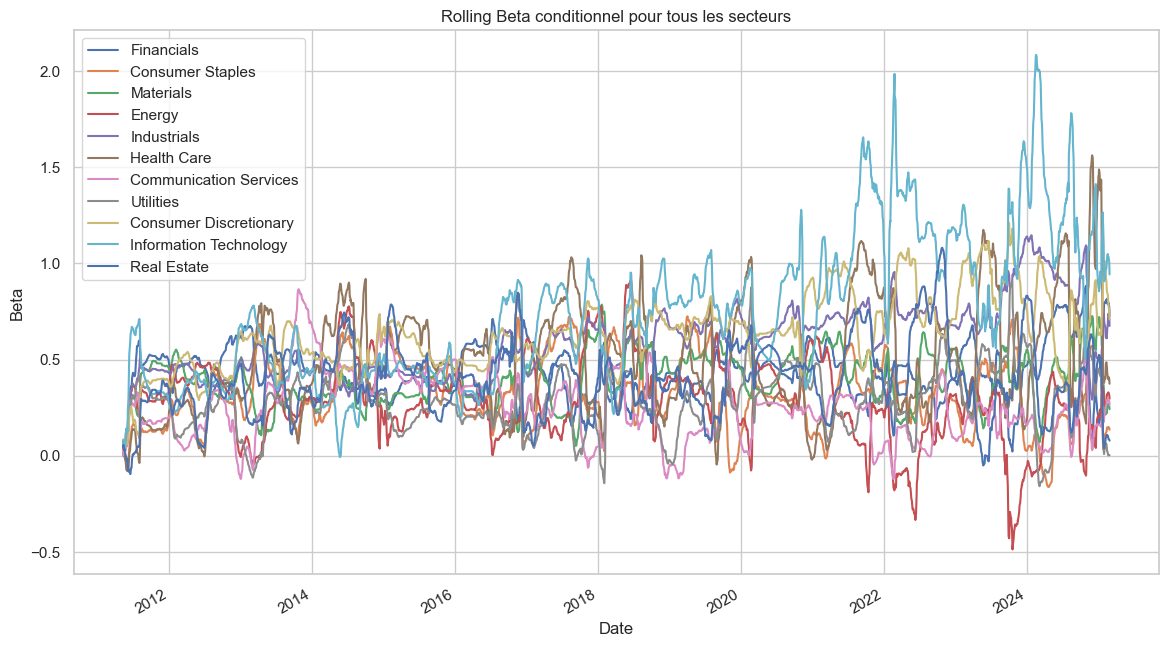

In [12]:
def rolling_beta_ewma(benchmark: pd.Series, sector: pd.Series, span: int = 60) -> pd.Series:
    """
    Calcule le beta roulant conditionnel à l'aide d'un estimateur EWMA.
    
    Args:
        benchmark (pd.Series): Série temporelle des rendements du benchmark.
        sector (pd.Series): Série temporelle des rendements du secteur.
        span (int): Période utilisée pour l'estimation EWMA (plus faible span => plus de poids aux observations récentes).
        
    Returns:
        pd.Series: Série temporelle du beta conditionnel.
    """
    # Calcul de la covariance conditionnelle (EWMA)
    rolling_cov = benchmark.ewm(span=span, adjust=False).cov(sector)
    # Calcul de la variance conditionnelle du benchmark (EWMA)
    rolling_var = benchmark.ewm(span=span, adjust=False).var()
    # Calcul du beta conditionnel : beta = cov / var
    beta = rolling_cov / rolling_var
    return beta

# Calculer les beta conditionnels pour tous les secteurs
beta_sectors = {}
for sector in sectors.columns:
    beta_sectors[sector] = rolling_beta_ewma(benchmark.squeeze(), sectors[sector], span=60)

# Tracer les beta conditionnels pour tous les secteurs sur un même graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for sector, beta_series in beta_sectors.items():
    beta_series.plot(label=sector)

plt.title("Rolling Beta conditionnel pour tous les secteurs")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.show()